In [1]:
#---import libraries relating to data manipulation, visualization---------------------------------------------------
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json

#-------import libraries to evaluate the deep learning model---------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, f1_score


import warnings
warnings.filterwarnings('ignore')

#------ import Deep Learning Libraries-------#

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import pickle


pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

import sys
sys.path.append('../../src')  # Add the 'src' directory to the path

#### Import Data Loading and Processing Functions<
from multimodal.helper_functions import  reproducible_comp, get_final_df, force_curve_reshape, acc_curves_reshape
from multimodal.model_architecture import MultimodalModel

reproducible_comp()

In [2]:
file_path = "../../data/processed_data/force_inner.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_inner, category_force_inner, category_names, df_force_inner = get_final_df(data, is_acc_data=0, is_multilabel=1)

file_path = "../../data/processed_data/acc_inner.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_acc_inner, category_acc_inner, category_names, df_acc_inner = get_final_df(data, is_acc_data=1, is_multilabel=1)

In [3]:
labels_force = category_force_inner.copy()
features_force = features_force_inner.copy()
feat_force = force_curve_reshape(features_force)
print("Force Features Shape: ", feat_force.shape)
print("Force Labels Shape: ", labels_force.shape)

labels_acc = category_acc_inner.copy()
features_acc = features_acc_inner.copy()
feat_acc = acc_curves_reshape(features_acc)
print("Acceleration Features Shape: ", feat_acc.shape)
print("Acceleration Labels Shape: ", labels_acc.shape)

Force Features Shape:  (1350, 150)
Force Labels Shape:  (1350, 4)
Acceleration Features Shape:  (1350, 1500)
Acceleration Labels Shape:  (1350, 4)


In [4]:
X_train_force, X_test_force, y_train_force, y_test_force = train_test_split(feat_force, labels_force, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels_force)

X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(feat_acc, labels_acc, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels_acc)                                                   

In [5]:
X_train_force, X_f, y_train_force, y_f = train_test_split(X_train_force, y_train_force, test_size=0.6, 
                                                    random_state=2, shuffle=True, stratify=y_train_force)

X_train_acc, X_a, y_train_acc, y_a = train_test_split(X_train_acc, y_train_acc, test_size=0.6, 
                                                    random_state=2, shuffle=True, stratify=y_train_acc)  

In [6]:
X_train_force = X_train_force.reshape(-1, 1, feat_force.shape[1])
X_test_force = X_test_force.reshape(-1, 1, feat_force.shape[1])

X_train_acc = X_train_acc.reshape(-1, 1, feat_acc.shape[1])
X_test_acc = X_test_acc.reshape(-1, 1, feat_acc.shape[1])

print(X_train_force.shape)
print(y_train_force.shape)
print(X_test_force.shape)
print(y_test_acc.shape)

print(X_train_acc.shape)
print(y_train_acc.shape)
print(X_test_acc.shape)
print(y_test_acc.shape)

(486, 1, 150)
(486, 4)
(135, 1, 150)
(135, 4)
(486, 1, 1500)
(486, 4)
(135, 1, 1500)
(135, 4)


In [7]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/multimodal/best_configs/multimodal_inner_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]

input_channels = 1
num_classes = 4
force_n_layers = best_params["force_n_layers"]
force_kernel_size = best_params["force_kernel_size"]
force_stride = best_params["force_stride"]
force_padding = best_params["force_padding"]
force_hidden_channels = best_params["force_hidden_channels"]
force_pooling_type = best_params["force_pooling_type"]
force_use_batch_norm = best_params["force_use_batch_norm"]
acc_n_layers = best_params["acc_n_layers"]
acc_kernel_size = best_params["acc_kernel_size"]
acc_stride = best_params["acc_stride"]
acc_padding = best_params["acc_padding"]
acc_hidden_channels = best_params["acc_hidden_channels"]
acc_pooling_type = best_params["force_stride"]
acc_use_batch_norm = best_params["acc_use_batch_norm"]
dropout_prob = best_params["dropout_prob"]
lr = best_params["lr"]

best_params_json = json.dumps(best_params, indent=4)
print(best_params_json)

{
    "lr": 0.0003027437119614072,
    "dropout_prob": 0.2554954189223444,
    "force_n_layers": 4,
    "force_kernel_size": 6,
    "force_stride": 2,
    "force_padding": 6,
    "force_hidden_channels": 256,
    "force_pooling_type": "max",
    "force_use_batch_norm": false,
    "acc_n_layers": 5,
    "acc_kernel_size": 7,
    "acc_stride": 2,
    "acc_padding": 4,
    "acc_hidden_channels": 114,
    "acc_pooling_type": "avg",
    "acc_use_batch_norm": true
}


# Training Loop with MultilabelStratifiedKFold Cross validation

In [8]:
from torch.utils.data import DataLoader, TensorDataset

def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy


# Convert your data to PyTorch tensors
x_train_force = torch.tensor(X_train_force, dtype=torch.float32)
y_train_force = torch.tensor(y_train_force, dtype=torch.float32)

x_train_acc = torch.tensor(X_train_acc, dtype=torch.float32)
y_train_acc = torch.tensor(y_train_acc, dtype=torch.float32)

x_test_force = torch.tensor(X_test_force, dtype=torch.float32)
y_test_force = torch.tensor(y_test_force, dtype=torch.long)

x_test_acc = torch.tensor(X_test_acc, dtype=torch.float32)
y_test_acc = torch.tensor(y_test_acc, dtype=torch.long)

# Define the number of folds
num_folds = 4  # You can adjust this as needed

# Initialize KFold cross-validation
mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lists to store training and validation loss values for each fold
train_losses = []
valid_losses = []

num_epochs = 50

for fold, (train_indices, valid_indices) in enumerate(mskf.split(x_train_force, y_train_force)):

    train_losses_fold = []  # Store training losses for this fold
    valid_losses_fold = []  # Store validation losses for this fold

    # Split the data into training and validation sets for this fold
    x_fold_train_force = x_train_force[train_indices]
    y_fold_train_force = y_train_force[train_indices]
    x_fold_valid_force = x_train_force[valid_indices]
    y_fold_valid_force = y_train_force[valid_indices]

    x_fold_train_acc = x_train_acc[train_indices]
    y_fold_train_acc = y_train_acc[train_indices]
    x_fold_valid_acc = x_train_acc[valid_indices]
    y_fold_valid_acc = y_train_acc[valid_indices]

    train_dataset_force = TensorDataset(x_fold_train_force, y_fold_train_force)
    valid_dataset_force = TensorDataset(x_fold_valid_force, y_fold_valid_force)

    train_dataset_acc = TensorDataset(x_fold_train_acc, y_fold_train_acc)
    valid_dataset_acc = TensorDataset(x_fold_valid_acc, y_fold_valid_acc)

    train_loader_force = DataLoader(train_dataset_force, batch_size=64, shuffle=True)
    valid_loader_force = DataLoader(valid_dataset_force, batch_size=64, shuffle=False)

    train_loader_acc = DataLoader(train_dataset_acc, batch_size=64, shuffle=True)
    valid_loader_acc = DataLoader(valid_dataset_acc, batch_size=64, shuffle=False)


    model = MultimodalModel(input_channels, num_classes, 
                 force_n_layers, force_kernel_size, force_stride, force_padding, force_hidden_channels,
                 force_pooling_type, force_use_batch_norm,
                 acc_n_layers, acc_kernel_size, acc_stride, acc_padding, acc_hidden_channels,
                 acc_pooling_type, acc_use_batch_norm, dropout_prob).to(device)
    
    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])


    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for (inputs_acc, labels), (inputs_force,lab) in zip(train_loader_acc, train_loader_force):
            inputs_acc, labels, inputs_force = inputs_acc.to(device), labels.to(device), inputs_force.to(device)

            optimizer.zero_grad()

            # Forward pass through the multimodal model
            outputs = model(inputs_force,inputs_acc)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses_fold.append(running_loss / len(train_loader_acc))
        
        # Validation loss calculation (similar to training loop)
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for (inputs_acc_valid, labels_valid), (inputs_force_valid,lab) in zip(valid_loader_acc, valid_loader_force):
                inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
                outputs_valid = model(inputs_force_valid, inputs_acc_valid)
                loss_valid = criterion(outputs_valid, labels_valid.float())
                valid_loss += loss_valid.item()

        valid_losses_fold.append(valid_loss / len(valid_loader_acc))

        if (epoch + 1) % 10 == 0:
            print(f"Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader_acc)}, Validation Loss: {valid_loss / len(valid_loader_acc)}")


    train_losses.append(train_losses_fold)
    valid_losses.append(valid_losses_fold)

    # Evaluation on the validation set for this fold
    model.eval()
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for (inputs_acc_valid, labels_valid), (inputs_force_valid,lab) in zip(valid_loader_acc, valid_loader_force):
            inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
            labels_valid = labels_valid.int()
            outputs_valid = model(inputs_force_valid, inputs_acc_valid)
            predicted = (outputs_valid > 0).int()
            y_true_valid.append(labels_valid.cpu().numpy())
            y_pred_valid.append(predicted.cpu().numpy())

    # Convert lists to NumPy arrays for calculations
    y_true_valid = np.array(y_true_valid[0]).reshape(-1,4)
    y_pred_valid = np.array(y_pred_valid[0]).reshape(-1,4)

    accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
    print(f"Multi-label Validation Accuracy: {accuracy * 100:.2f}%")


Fold 1, Epoch 10/50, Training Loss: 0.6287326216697693, Validation Loss: 0.6332983076572418
Fold 1, Epoch 20/50, Training Loss: 0.6275352239608765, Validation Loss: 0.6306394040584564
Fold 1, Epoch 30/50, Training Loss: 0.6065097153186798, Validation Loss: 0.6039224565029144
Fold 1, Epoch 40/50, Training Loss: 0.36016801993052167, Validation Loss: 0.4010866582393646
Fold 1, Epoch 50/50, Training Loss: 0.28154230614503223, Validation Loss: 0.37086121737957
Multi-label Validation Accuracy: 82.81%
Fold 2, Epoch 10/50, Training Loss: 0.6292068064212799, Validation Loss: 0.636063277721405
Fold 2, Epoch 20/50, Training Loss: 0.6207922697067261, Validation Loss: 0.6260656118392944
Fold 2, Epoch 30/50, Training Loss: 0.433490330974261, Validation Loss: 0.4524648040533066
Fold 2, Epoch 40/50, Training Loss: 0.34826422731081647, Validation Loss: 0.34100979566574097
Fold 2, Epoch 50/50, Training Loss: 0.2673616409301758, Validation Loss: 0.2942695915699005
Multi-label Validation Accuracy: 85.94%


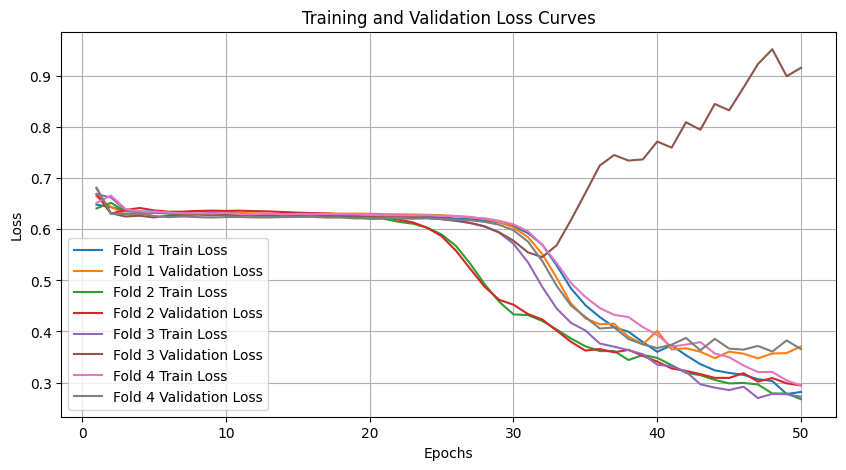

In [9]:
plt.figure(figsize=(10, 5))

# Plot training and validation loss curves for each fold
for fold in range(num_folds):
    plt.plot(range(1, num_epochs + 1), train_losses[fold], label=f'Fold {fold + 1} Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses[fold], label=f'Fold {fold + 1} Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
torch.save(model, '../../artifacts/multimodal_inner_supervised_50P.pth')

# Evaluation on Test Data

In [11]:
# Evaluation on test set
model = torch.load('../../artifacts/multimodal_inner_supervised_50P.pth')


Multi-label Accuracy: 81.48%
Multi-label F1-Score: 68.45%
Classification Report:
               precision    recall  f1-score   support

        Dünn       0.83      1.00      0.90        52
    Referenz       0.71      0.63      0.67        27
        Slug       0.85      0.41      0.55        54
        Worn       0.72      0.54      0.62        54

   micro avg       0.78      0.64      0.71       187
   macro avg       0.78      0.64      0.68       187
weighted avg       0.79      0.64      0.68       187
 samples avg       0.73      0.65      0.66       187



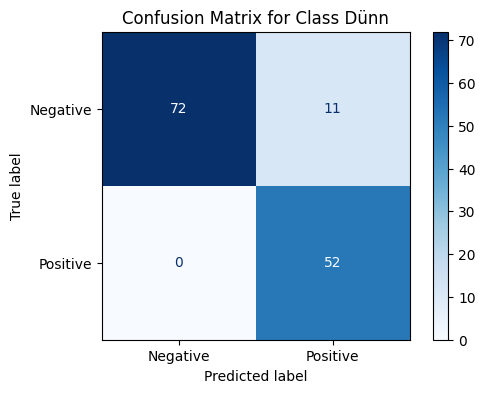

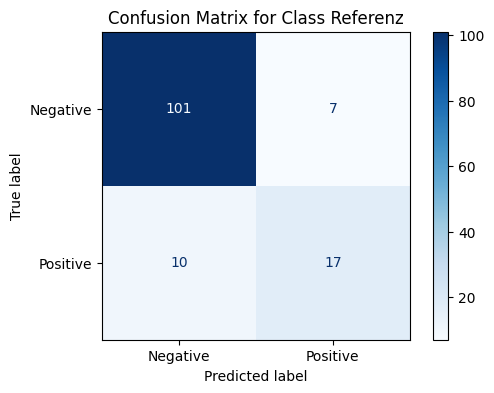

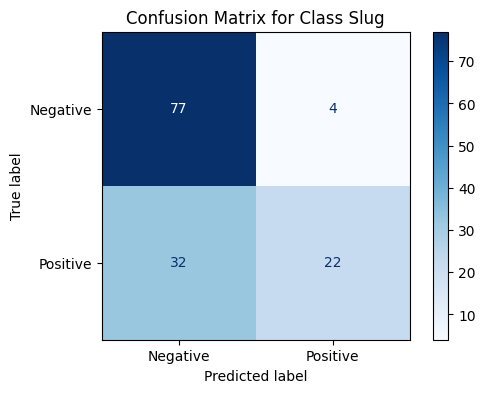

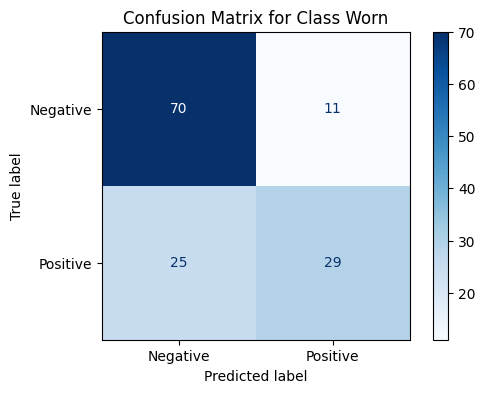

In [12]:
# Evaluation on test set
model.eval()
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for inputs_force_test, inputs_acc_test, labels_test in zip(x_test_force,x_test_acc, y_test_force):
        inputs_force_test, inputs_acc_test, labels_test = inputs_force_test.to(device), inputs_acc_test.to(device), labels_test.to(device)
        
        labels_test = labels_test.int()
        
        outputs = model(inputs_force_test.unsqueeze(0), inputs_acc_test.unsqueeze(0)) 
        predicted = (outputs > 0).int() 
        
        y_true_test.append(labels_test.cpu().numpy())
        y_pred_test.append(predicted.cpu().numpy())

# Convert lists to NumPy arrays for calculations
y_true_test = np.array(y_true_test).reshape(-1,4)
y_pred_test = np.array(y_pred_test).reshape(-1,4)


accuracy = multi_label_accuracy(y_true_test, y_pred_test)
print(f"Multi-label Accuracy: {accuracy * 100:.2f}%")

f1 = f1_score(y_true_test, y_pred_test, average='macro')
print(f"Multi-label F1-Score: {f1 * 100:.2f}%")

# Generate a classification report
report = classification_report(y_true_test, y_pred_test, target_names=category_names)
print("Classification Report:\n", report)

# Compute the multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(y_true_test, y_pred_test)

# Visualize each confusion matrix with sample counts
for i, matrix in enumerate(conf_matrix):
    total_samples = matrix.sum()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
    fig, ax = plt.subplots(figsize=(6, 4))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
    ax.set_title(f'Confusion Matrix for Class {category_names[i]}')
    
    plt.show()

In [13]:
print(summary(model, [(1, 150), (1, 1500)]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 256, 79]           1,792
              ReLU-2              [-1, 256, 79]               0
         MaxPool1d-3              [-1, 256, 39]               0
            Conv1d-4              [-1, 256, 23]         393,472
              ReLU-5              [-1, 256, 23]               0
         MaxPool1d-6              [-1, 256, 11]               0
            Conv1d-7               [-1, 256, 9]         393,472
              ReLU-8               [-1, 256, 9]               0
         MaxPool1d-9               [-1, 256, 4]               0
           Conv1d-10               [-1, 256, 6]         393,472
             ReLU-11               [-1, 256, 6]               0
        MaxPool1d-12               [-1, 256, 3]               0
           Conv1d-13             [-1, 114, 751]             912
             ReLU-14             [-1, 1

# Thank You